# Importing Necessary Libraries

In [ ]:
try:
    from ibm_watson_machine_learning import APIClient
    print('IBM Watson is loaded')
except:
    from IPython.display import clear_output
    !pip install --upgrade ibm-watson-machine-learning
    clear_output()
    print('RESTART THE KERNEL and run this cell again before proceeding')

IBM Watson is loaded


In [ ]:
import os
import sys
import pickle
from getpass import getpass
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import  XGBClassifier
from xgboost import plot_tree
from sklearn import tree
import matplotlib

In [ ]:
from google.colab import drive
drive.mount('gdrive')
main_path = '/content/gdrive/MyDrive/Interstellar Explorers'

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


# Let's load our data

We'll use NASA Exoplanet Archive's API endpoints to extract our data.

The API documentation and various endpoints are available at:
[https://exoplanetarchive.ipac.caltech.edu/docs/program_interfaces.html](https://exoplanetarchive.ipac.caltech.edu/docs/program_interfaces.html)

---
A sample query looks:
<img src='https://exoplanetarchive.ipac.caltech.edu/images/help/api_breakdown.jpg'>

---
To acquire kepler object of interest data, the query would look like: https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative

Let's use it to load data into a pandas DataFrame as follows:

In [ ]:
data = pd.read_csv('https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative')
ra=pd.read_csv('https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=ra')
dec=pd.read_csv('https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=dec')
dicco=pd.read_csv('https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=koi_dicco_msky')
koi_fittype=pd.read_csv('https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=koi_fittype')
dikco=pd.read_csv('https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=koi_dikco_msky')

data = data.drop(['ra_str', 'dec_str', 'koi_kepmag_err'], axis=1)
data['ra'] = ra
data['dec'] = dec
data['dicco'] = dicco
data['dikco'] = dikco
data['koi_fittype'] = koi_fittype

data.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_kepmag,ra,dec,dicco,dikco,koi_fittype
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,15.347,291.93423,48.141651,0.200,0.320,LS+MCMC
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,15.347,291.93423,48.141651,0.390,0.500,LS+MCMC
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,q1_q17_dr25_tce,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,15.436,297.00482,48.134129,0.042,0.027,LS+MCMC
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,q1_q17_dr25_tce,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,15.597,285.53461,48.285210,0.289,0.276,LS+MCMC
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,q1_q17_dr25_tce,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,15.509,288.75488,48.226200,0.100,0.070,LS+MCMC


In [ ]:
data.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_kepmag,ra,dec,dicco,dikco,koi_fittype
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,15.347,291.93423,48.141651,0.200,0.320,LS+MCMC
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,15.347,291.93423,48.141651,0.390,0.500,LS+MCMC
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,q1_q17_dr25_tce,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,15.436,297.00482,48.134129,0.042,0.027,LS+MCMC
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,q1_q17_dr25_tce,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,15.597,285.53461,48.285210,0.289,0.276,LS+MCMC
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,q1_q17_dr25_tce,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,15.509,288.75488,48.226200,0.100,0.070,LS+MCMC


In [ ]:
data.shape

(9564, 52)

In [ ]:
def transform_koi_fittype(l):
    if l == 'LS+MCMC':
        return 0
    elif l =='MCMC':
        return 1
    elif l == 'LS':
        return 2
    else:
        return None

data['koi_fittype'] = data['koi_fittype'].map(lambda x: transform_koi_fittype(x))

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2360 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_period_err1    9110 non-null   float64
 12  koi_period_err2    9110 non-null   float64
 13  koi_time0bk        9564 non-null   float64
 14  koi_time0bk_err1   9110 non-null   float64
 15  koi_time0bk_err2   9110 non-null   float64
 16  koi_impact         9201 

# EDA

This documentation is written form [the official site of exoplanet archives](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html) 

#### Identification Columns

| Dataset Column Name| Table Label | Description |
---------------------|-------------|-------------|                  
| kepid              |	Kepler Identification | Target identification number, as listed in the Kepler Input Catalog  [(KIC)](https://ui.adsabs.harvard.edu/abs/2011AJ....142..112B/abstract). The survey's purpose was to identify stars for the Kepler exoplanet survey by magnitude and color.  
|                         
| kepoi_name | KOI Name | A number used to identify and track a Kepler Object of Interest (KOI).A KOI name has an integer and a decimal part of the format KNNNNN.DD. The integer part designates the target star; the two-digit decimal part identifies a unique transiting object associated with that star.

#### Exoplanet Archive Information

| Dataset Column Name| Table Label | Description |
---------------------|-------------|-------------|                  
|
| kepler_name | Kepler Name | Kepler number name in the form "Kepler-N," plus a lower-case letter, identifying the planet. These are intended to clearly indicate a class of objects that have been confirmed or validated as planets—a step up from the planet candidate designation.
|
|koi_disposition | Exoplanet Archive Disposition | Current values are CANDIDATE, FALSE POSITIVE, NOT DISPOSITIONED or CONFIRMED. Designations of CANDIDATE, FALSE POSITIVE, and NOT DISPOSITIONED are taken from the [Disposition Using Kepler Data](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html#pdisposition).
|
| koi_vet_stat | Vetting Status | 


#### Project Disposition Columns

| Dataset Column Name| Table Label | Description |
---------------------|-------------|-------------|
|             
|koi_pdisposition | Disposition Using Kepler Data | The pipeline flag that designates the most probable physical explanation of the KOI.Typical values are FALSE POSITIVE, NOT DISPOSITIONED, and CANDIDATE. The value of this flag may change over time as the evaluation of KOIs proceeds to deeper levels of analysis using Kepler time-series pixel and light curve data, or follow-up observations.
|koi_score | Disposition Score | A value between 0 and 1 that indicates the confidence in the KOI disposition. For CANDIDATEs, a higher value indicates more confidence in its disposition, while for FALSE POSITIVEs, a higher value indicates less confidence in that disposition.
|
|koi_fpflag_nt | Not Transit-Like Flag | A KOI whose light curve is not consistent with that of a transiting planet. This includes, but is not limited to, instrumental artifacts, non-eclipsing variable stars, and spurious (very low SNR) detections.
|
|koi_fpflag_ss | Stellar Eclipse Flag | A KOI that is observed to have a significant secondary event, transit shape, or out-of-eclipse variability, which indicates that the transit-like event is most likely caused by an eclipsing binary.  However, self-luminous, hot Jupiters with a visible secondary eclipse will also have this flag set, but with a disposition of PC.|
|koi_fpflag_co | Centroid Offset Flag | The source of the signal is from a nearby star, as inferred by measuring the centroid location of the image both in and out of transit, or by the strength of the transit signal in the target's outer (halo) pixels as compared to the transit signal from the pixels in the optimal (or core) aperture.|
|koi_fpflag_ec | Ephemeris Match Indicates Contamination Flag | The KOI shares the same period and epoch as another object and is judged to be the result of flux contamination in the aperture or electronic crosstalk.|

#### Transit Properties

| Dataset Column Name| Table Label | Description | Uncertainties Column(positive +)(negative -)| Displayed String Name|
|---------------------|-------------|-------------|---|---|
|koi_period | Orbital Period (days) | The interval between consecutive planetary transits. | koi_period_err1, koi_period_err2 | koi_period_str|
|koi_time0bk | Transit Epoch (BJD - 2,454,833.0) | The time corresponding to the center of the first detected transit in Barycentric Julian Day (BJD) minus a constant offset of 2,454,833.0 days. The offset corresponds to 12:00 on Jan 1, 2009 UTC. | koi_time0bk_err1, koi_time0bk_err2 | koi_time0bk_str|
|koi_time0 | Transit Epoch in BJD | The time corresponding to the center of the first detected transit in Barycentric Julian Day (BJD). | koi_time0_err1, koi_time0_err2 | koi_time0_str|
|koi_impact | Impact Parameter | The sky-projected distance between the center of the stellar disc and the center of the planet disc at conjunction, normalized by the stellar radius. | koi_impact_err1, koi_impact_err2 | koi_impact_str|
|koi_duration | Transit Duration (hours) | The duration of the observed transits. Duration is measured from first contact between the planet and star until last contact. | koi_duration_err1, koi_duration_err2 | koi_duration_str|
|koi_depth | Transit Depth (parts per million) | The fraction of stellar flux lost at the minimum of the planetary transit. | koi_depth_err1, koi_depth_err2 | koi_depth_str|
|koi_prad | Planetary Radius (Earth radii) | The radius of the planet. Planetary radius is the product of the planet star radius ratio and the stellar radius. | koi_prad_err1, koi_prad_err2 | koi_prad_str|
|koi_teq | Equilibrium Temperature (Kelvin) | Approximation for the temperature of the planet. | koi_teq_err1, koi_teq_err2 | koi_teq_str|
|koi_insol | Insolation Flux [Earth flux] | Insolation flux is another way to give the equilibrium temperature. It depends on the stellar parameters (specifically the stellar radius and temperature), and on the semi-major axis of the planet. | | | |

####  




Let's rename the columns to user-friendly names

In [ ]:
data = data.rename(columns={'kepid':'KepID',
                            'kepoi_name':'KOIName',
                            'kepler_name':'KeplerName',
                            'koi_disposition':'ExoplanetArchiveDisposition',
                            'koi_pdisposition':'DispositionUsingKeplerData',
                            'koi_score':'DispositionScore',
                            'koi_fpflag_nt':'NotTransit-LikeFalsePositiveFlag',
                            'koi_fpflag_ss':'koi_fpflag_ss',
                            'koi_fpflag_co':'CentroidOffsetFalsePositiveFlag',
                            'koi_fpflag_ec':'EphemerisMatchIndicatesContaminationFalsePositiveFlag',
                            'koi_period':'OrbitalPeriod[days',
                            'koi_period_err1':'OrbitalPeriodUpperUnc.[days',
                            'koi_period_err2':'OrbitalPeriodLowerUnc.[days',
                            'koi_time0bk':'TransitEpoch[BKJD',
                            'koi_time0bk_err1':'TransitEpochUpperUnc.[BKJD',
                            'koi_time0bk_err2':'TransitEpochLowerUnc.[BKJD',
                            'koi_impact':'ImpactParamete',
                            'koi_impact_err1':'ImpactParameterUpperUnc',
                            'koi_impact_err2':'ImpactParameterLowerUnc',
                            'koi_duration':'TransitDuration[hrs',
                            'koi_duration_err1':'TransitDurationUpperUnc.[hrs',
                            'koi_duration_err2':'TransitDurationLowerUnc.[hrs',
                            'koi_depth':'TransitDepth[ppm',
                            'koi_depth_err1':'TransitDepthUpperUnc.[ppm',
                            'koi_depth_err2':'TransitDepthLowerUnc.[ppm',
                            'koi_prad':'PlanetaryRadius[Earthradii',
                            'koi_prad_err1':'PlanetaryRadiusUpperUnc.[Earthradii',
                            'koi_prad_err2':'PlanetaryRadiusLowerUnc.[Earthradii',
                            'koi_teq':'EquilibriumTemperature[K',
                            'koi_teq_err1':'EquilibriumTemperatureUpperUnc.[K',
                            'koi_teq_err2':'EquilibriumTemperatureLowerUnc.[K',
                            'koi_insol':'InsolationFlux[Earthflux',
                            'koi_insol_err1':'InsolationFluxUpperUnc.[Earthflux',
                            'koi_insol_err2':'InsolationFluxLowerUnc.[Earthflux',
                            'koi_model_snr':'TransitSignal-to-Nois',
                            'koi_tce_plnt_num':'TCEPlanetNumbe',
                            'koi_tce_delivname':'TCEDeliver',
                            'koi_steff':'StellarEffectiveTemperature[K',
                            'koi_steff_err1':'StellarEffectiveTemperatureUpperUnc.[K',
                            'koi_steff_err2':'StellarEffectiveTemperatureLowerUnc.[K',
                            'koi_slogg':'StellarSurfaceGravity[log10(cm/s**2)',
                            'koi_slogg_err1':'StellarSurfaceGravityUpperUnc.[log10(cm/s**2)',
                            'koi_slogg_err2':'StellarSurfaceGravityLowerUnc.[log10(cm/s**2)',
                            'koi_srad':'StellarRadius[Solarradii',
                            'koi_srad_err1':'StellarRadiusUpperUnc.[Solarradii',
                            'koi_srad_err2':'StellarRadiusLowerUnc.[Solarradii',
                            'ra':'RA[decimaldegrees',
                            'dec':'Dec[decimaldegrees',
                            'koi_kepmag':'Kepler-band[mag]'
                            })
data.head()

,KepID,KOIName,KeplerName,ExoplanetArchiveDisposition,DispositionUsingKeplerData,DispositionScore,NotTransit-LikeFalsePositiveFlag,koi_fpflag_ss,CentroidOffsetFalsePositiveFlag,EphemerisMatchIndicatesContaminationFalsePositiveFlag,OrbitalPeriod[days,OrbitalPeriodUpperUnc.[days,OrbitalPeriodLowerUnc.[days,TransitEpoch[BKJD,TransitEpochUpperUnc.[BKJD,TransitEpochLowerUnc.[BKJD,ImpactParamete,ImpactParameterUpperUnc,ImpactParameterLowerUnc,TransitDuration[hrs,TransitDurationUpperUnc.[hrs,TransitDurationLowerUnc.[hrs,TransitDepth[ppm,TransitDepthUpperUnc.[ppm,TransitDepthLowerUnc.[ppm,PlanetaryRadius[Earthradii,PlanetaryRadiusUpperUnc.[Earthradii,PlanetaryRadiusLowerUnc.[Earthradii,EquilibriumTemperature[K,EquilibriumTemperatureUpperUnc.[K,EquilibriumTemperatureLowerUnc.[K,InsolationFlux[Earthflux,InsolationFluxUpperUnc.[Earthflux,InsolationFluxLowerUnc.[Earthflux,TransitSignal-to-Nois,TCEPlanetNumbe,TCEDeliver,StellarEffectiveTemperature[K,StellarEffectiveTemperatureUpperUnc.[K,StellarEffectiveTemperatureLowerUnc.[K,StellarSurfaceGravity[log10(cm/s**2),StellarSurfaceGravityUpperUnc.[log10(cm/s**2),StellarSurfaceGravityLowerUnc.[log10(cm/s**2),StellarRadius[Solarradii,StellarRadiusUpperUnc.[Solarradii,StellarRadiusLowerUnc.[Solarradii,Kepler-band[mag],RA[decimaldegrees,Dec[decimaldegrees,dicco,dikco,koi_fittype
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,15.347,291.93423,48.141651,0.200,0.320,0.0
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,15.347,291.93423,48.141651,0.390,0.500,0.0
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,q1_q17_dr25_tce,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,15.436,297.00482,48.134129,0.042,0.027,0.0
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,q1_q17_dr25_tce,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,15.597,285.53461,48.285210,0.289,0.276,0.0
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,q1_q17_dr25_tce,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,15.509,288.75488,48.226200,0.100,0.070,0.0


In [ ]:
data['ExoplanetCandidate'] = data['DispositionUsingKeplerData'].apply(lambda x: 1 if x == 'CANDIDATE' else 0)
data['ExoplanetConfirmed'] = data['ExoplanetArchiveDisposition'].apply(lambda x: 2 if x == 'CONFIRMED' else 1 if x == 'CANDIDATE' else 0 )

In [ ]:
data.drop(columns=['KeplerName','KOIName','EquilibriumTemperatureUpperUnc.[K',
                 'KepID','ExoplanetArchiveDisposition','DispositionUsingKeplerData',
                 'NotTransit-LikeFalsePositiveFlag','koi_fpflag_ss','CentroidOffsetFalsePositiveFlag',
                 'EphemerisMatchIndicatesContaminationFalsePositiveFlag','TCEDeliver',
                 'EquilibriumTemperatureLowerUnc.[K'], inplace=True)

In [ ]:
data.dropna(inplace=True)
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)].astype(np.float64)

In [ ]:
data.shape

(7305, 42)

In [ ]:
data.head()

,DispositionScore,OrbitalPeriod[days,OrbitalPeriodUpperUnc.[days,OrbitalPeriodLowerUnc.[days,TransitEpoch[BKJD,TransitEpochUpperUnc.[BKJD,TransitEpochLowerUnc.[BKJD,ImpactParamete,ImpactParameterUpperUnc,ImpactParameterLowerUnc,TransitDuration[hrs,TransitDurationUpperUnc.[hrs,TransitDurationLowerUnc.[hrs,TransitDepth[ppm,TransitDepthUpperUnc.[ppm,TransitDepthLowerUnc.[ppm,PlanetaryRadius[Earthradii,PlanetaryRadiusUpperUnc.[Earthradii,PlanetaryRadiusLowerUnc.[Earthradii,EquilibriumTemperature[K,InsolationFlux[Earthflux,InsolationFluxUpperUnc.[Earthflux,InsolationFluxLowerUnc.[Earthflux,TransitSignal-to-Nois,TCEPlanetNumbe,StellarEffectiveTemperature[K,StellarEffectiveTemperatureUpperUnc.[K,StellarEffectiveTemperatureLowerUnc.[K,StellarSurfaceGravity[log10(cm/s**2),StellarSurfaceGravityUpperUnc.[log10(cm/s**2),StellarSurfaceGravityLowerUnc.[log10(cm/s**2),StellarRadius[Solarradii,StellarRadiusUpperUnc.[Solarradii,StellarRadiusLowerUnc.[Solarradii,Kepler-band[mag],RA[decimaldegrees,Dec[decimaldegrees,dicco,dikco,koi_fittype,ExoplanetCandidate,ExoplanetConfirmed
0,1.000,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,93.59,29.45,-16.65,35.8,1.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,15.347,291.93423,48.141651,0.200,0.320,0.0,1.0,2.0
1,0.969,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,9.11,2.87,-1.62,25.8,2.0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,15.347,291.93423,48.141651,0.390,0.500,0.0,1.0,2.0
2,0.000,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,39.30,31.04,-10.49,76.3,1.0,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,15.436,297.00482,48.134129,0.042,0.027,0.0,1.0,1.0
3,0.000,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,891.96,668.95,-230.35,505.6,1.0,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,15.597,285.53461,48.285210,0.289,0.276,0.0,0.0,0.0
4,1.000,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,926.16,874.33,-314.24,40.9,1.0,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,15.509,288.75488,48.226200,0.100,0.070,0.0,1.0,2.0


In [ ]:
X = data.drop(columns=['ExoplanetCandidate','ExoplanetConfirmed'])
y = data.ExoplanetCandidate

# Splitting Data into training and testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Normalizing our data

In [ ]:
mean = np.mean(X_train,axis = 0)
std = np.std(X_train,axis = 0)
X_train_normalized = (X_train - mean)/std

# Initial Models

## Logistic Regression from scratch

In [ ]:
m, n = X_train_normalized.shape
print("Shape of X:",X_train_normalized.shape)
print("Shape of Y:",y_train.shape)

Shape of X: (5478, 40)
Shape of Y: (5478,)


In [ ]:
X0 = np.ones((m,1))
X = np.hstack((X0,X_train_normalized))
y = np.array(y_train).reshape(-1,1)

In [ ]:
X.shape

(5478, 41)

In [ ]:
y.shape

(5478, 1)

In [ ]:
theta=np.zeros((n+1,1))

In [ ]:
def sigmoid(Z):
    # return 1/(1 + np.exp(-Z))
    return np.exp(-np.logaddexp(0, -Z))

def cost(pred,y):
    return (-1/m)*(y.T@np.log(pred) + (1 - y).T @ np.log( 1 - pred ))   

def gradient(X,prediction,y):
    return (1/m) * (X.T @ (prediction - y))


def prediction(X,theta):
    Z = X @ theta
    return sigmoid(Z)

def LogisticRegression(X,y,theta,alpha,epoch):
    
    j_history=[]
    
    for i in range(epoch):
        
        pred = prediction(X,theta)
        J = cost(pred,y)
        g = gradient(X,pred,y)
        theta = theta - alpha*g
        j_history = np.append(j_history,J)
        
        print("Epoch:",i+1,"    ","cost:",np.round(np.float(J),5))
    
    x = np.linspace(0,epoch,epoch)
    plt.ylabel("cost function")
    plt.plot(x,j_history,color='r')
    plt.xlabel("No. of iterations")
    plt.title("Cost function v/s epochs ")
    
    return theta,pred

Epoch: 1      cost: 0.69315
Epoch: 2      cost: 0.64675
Epoch: 3      cost: 0.60773
Epoch: 4      cost: 0.5745
Epoch: 5      cost: 0.54583
Epoch: 6      cost: 0.52082
Epoch: 7      cost: 0.49879
Epoch: 8      cost: 0.47921
Epoch: 9      cost: 0.46168
Epoch: 10      cost: 0.44586
Epoch: 11      cost: 0.43151
Epoch: 12      cost: 0.41841
Epoch: 13      cost: 0.40639
Epoch: 14      cost: 0.39533
Epoch: 15      cost: 0.38509
Epoch: 16      cost: 0.37558
Epoch: 17      cost: 0.36673
Epoch: 18      cost: 0.35845
Epoch: 19      cost: 0.3507
Epoch: 20      cost: 0.34342
Epoch: 21      cost: 0.33656
Epoch: 22      cost: 0.33009
Epoch: 23      cost: 0.32397
Epoch: 24      cost: 0.31818
Epoch: 25      cost: 0.31268
Epoch: 26      cost: 0.30746
Epoch: 27      cost: 0.30249
Epoch: 28      cost: 0.29775
Epoch: 29      cost: 0.29323
Epoch: 30      cost: 0.28891
Epoch: 31      cost: 0.28478
Epoch: 32      cost: 0.28082
Epoch: 33      cost: 0.27703
Epoch: 34      cost: 0.27339
Epoch: 35      cost: 0.26

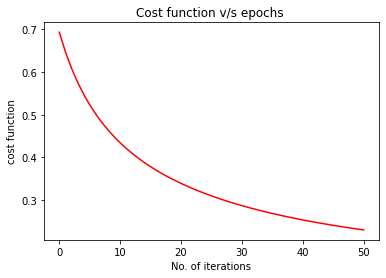

In [ ]:
theta=np.zeros((n+1,1))

theta, pred = LogisticRegression(X,y,theta,alpha=0.1,epoch=50)

In [ ]:
predict = prediction(X,theta)
print(predict)
for i in range(len(predict)):
    if predict[i]>=0.50:
        predict[i]=1
    else:
        predict[i]=0
k = np.double(predict == y)
acc = np.round(np.mean(k)*100, 5)
print(acc)

[[0.05889023]
 [0.15714833]
 [0.02395036]
 ...
 [0.00108765]
 [0.94842552]
 [0.81732471]]
95.63709


In [ ]:
X0_test = np.ones((m,1))
X_test_padded = np.hstack((np.ones((X_test.shape[0],1)),X_test))

predict = prediction(X_test_padded,theta)
print(predict)
for i in range(len(predict)):
    if predict[i]>=0.50:
        predict[i]=1
    else:
        predict[i]=0
k = np.double(predict == np.array(y_test).reshape(-1,1))
acc = np.round(np.mean(k)*100, 5)
print(acc)

[[2.69667313e-266]
 [0.00000000e+000]
 [0.00000000e+000]
 ...
 [2.23178404e-237]
 [1.48241316e-246]
 [7.04706816e-283]]
44.88232


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=10, max_iter=100000, class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

Evaluation Metrics:
Accuracy: 0.956759715380405
Recall: 0.9543197616683218
F1 Score: 0.960519740129935
Precision: 0.9668008048289738


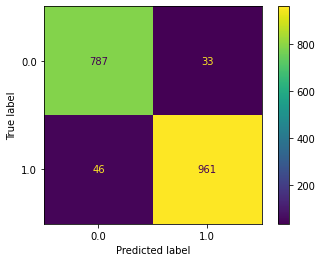

In [ ]:
y_pred = lr.predict(X_test)
print('Evaluation Metrics:')
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 Score: ' + str(f1_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
plot_confusion_matrix(lr, X_test, y_test, values_format='0.0f')
plt.show()

## Support Vector Classifier

In [ ]:
svclassifier = SVC(kernel='rbf', class_weight='balanced', degree=2)

In [ ]:
svclassifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Evaluation Metrics:
Accuracy: 0.7192118226600985
Recall: 0.9692154915590864
F1 Score: 0.7918864097363084
Precision: 0.6694101508916324


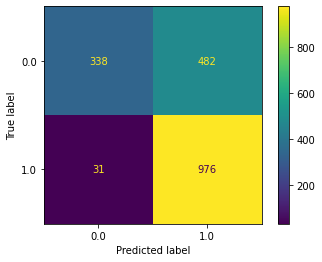

In [ ]:
y_pred = svclassifier.predict(X_test)
print('Evaluation Metrics:')
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 Score: ' + str(f1_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
plot_confusion_matrix(svclassifier,X_test,y_test, values_format='0.0f')
plt.show()

___________________________________________________________
Work done till here before Mid-Sem Presentation
___________________________________________________________

# XGBoost (for feature understanding)

In [ ]:
def change_columns(df):
    # df = pd.DataFrame(df)
    result = df.copy()   
    columns = result.columns
    new = []
    s = '[]<>,*'

    for column in list(columns):
        new.append(column.translate({ord(i): None for i in s}))

    result.columns = new
    return result

In [ ]:
xgb_clf = XGBClassifier()

xgb_clf.fit(change_columns(X_train), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Evaluation Metrics:
Accuracy: 0.9768163563344286
Recall: 0.9737738419618529
F1 Score: 0.9782720273738238
Precision: 0.9828119628738398


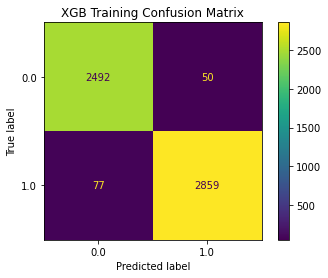

In [ ]:
y_pred = xgb_clf.predict(change_columns(X_train))
print('Evaluation Metrics:')
print('Accuracy: ' + str(accuracy_score(y_train, y_pred)))
print('Recall: ' + str(recall_score(y_train, y_pred)))
print('F1 Score: ' + str(f1_score(y_train, y_pred)))
print('Precision: ' + str(precision_score(y_train, y_pred)))
plot_confusion_matrix(xgb_clf,change_columns(X_train),y_train, values_format='0.0f')
plt.title("XGB Training Confusion Matrix")
plt.show()

Evaluation Metrics:
Accuracy: 0.9666119321291735
Recall: 0.968222442899702
F1 Score: 0.9696668324216808
Precision: 0.9711155378486056


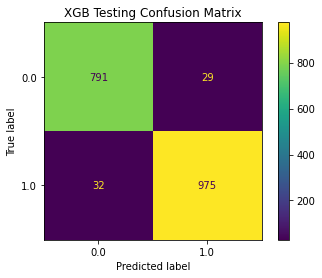

In [ ]:
y_pred = xgb_clf.predict(change_columns(X_test))
print('Evaluation Metrics:')
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 Score: ' + str(f1_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
plot_confusion_matrix(xgb_clf,change_columns(X_test),y_test, values_format='0.0f')
plt.title("XGB Testing Confusion Matrix")
plt.show()

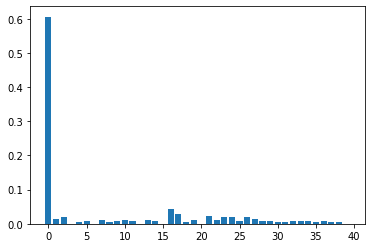

In [ ]:
plt.bar(range(len(xgb_clf.feature_importances_)), xgb_clf.feature_importances_)
plt.show()

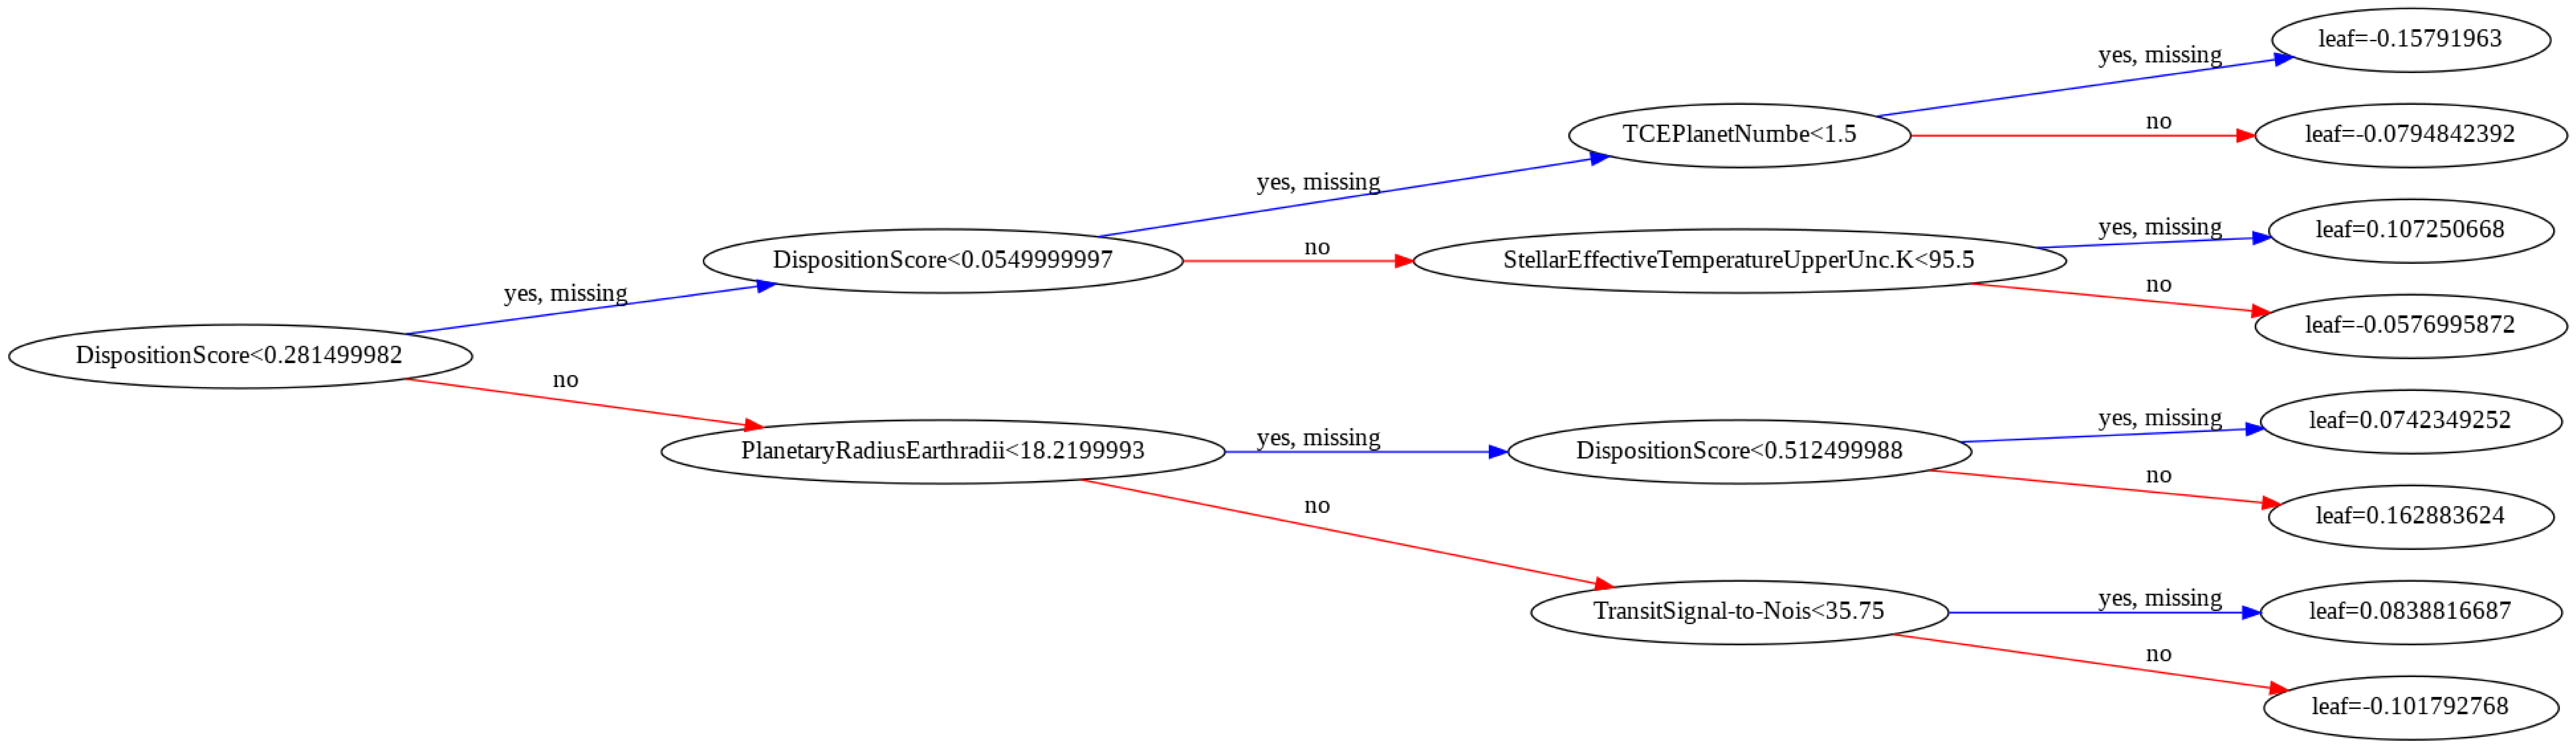

In [ ]:
plot_tree(xgb_clf, num_trees=2, rankdir='LR')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(200, 200)
fig.show()

# Feature Selection (from XGBoost)

As seen from the above tree diagram, xgboost shows that the top important features are disposition score, planetary radius, TEC planet number, Stellar Temperature, and Transit Signal-to-noise ratio.

Let's subset our data to these 5 features and compare all three models:

In [ ]:
idx = [0,16,24,26,23] #column indexes for our selected features

small_X_train = X_train.iloc[:,idx]
small_X_test = X_test.iloc[:,idx]

# Final Models with selected features

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=10, max_iter=100000, class_weight='balanced')
lr.fit(small_X_train, y_train)

LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

Evaluation Metrics:
Accuracy: 0.9627805145046524
Recall: 0.9563058589870904
F1 Score: 0.9658976930792377
Precision: 0.9756838905775076


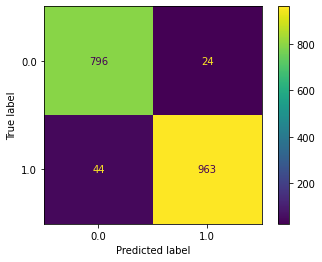

In [ ]:
y_pred = lr.predict(small_X_test)
print('Evaluation Metrics:')
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 Score: ' + str(f1_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
plot_confusion_matrix(lr, small_X_test, y_test, values_format='0.0f')
plt.show()

## Support Vector Classifier

In [ ]:
svclassifier = SVC(kernel='rbf', class_weight='balanced', degree=2)

In [ ]:
svclassifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Evaluation Metrics:
Accuracy: 0.7192118226600985
Recall: 0.9692154915590864
F1 Score: 0.7918864097363084
Precision: 0.6694101508916324


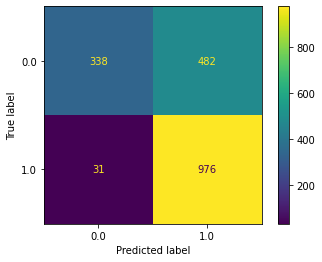

In [ ]:
y_pred = svclassifier.predict(X_test)
print('Evaluation Metrics:')
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 Score: ' + str(f1_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
plot_confusion_matrix(svclassifier,X_test,y_test, values_format='0.0f')
plt.show()

## XGBoost Decision Tree

In [ ]:
xgb_clf = XGBClassifier()

xgb_clf.fit(change_columns(small_X_train), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Evaluation Metrics:
Accuracy: 0.9698795180722891
Recall: 0.9686648501362398
F1 Score: 0.9718093285494618
Precision: 0.9749742886527254


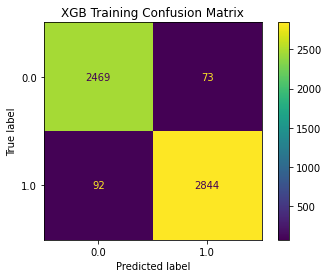

In [ ]:
y_pred = xgb_clf.predict(change_columns(small_X_train))
print('Evaluation Metrics:')
print('Accuracy: ' + str(accuracy_score(y_train, y_pred)))
print('Recall: ' + str(recall_score(y_train, y_pred)))
print('F1 Score: ' + str(f1_score(y_train, y_pred)))
print('Precision: ' + str(precision_score(y_train, y_pred)))
plot_confusion_matrix(xgb_clf,change_columns(small_X_train),y_train, values_format='0.0f')
plt.title("XGB Training Confusion Matrix")
plt.show()

Evaluation Metrics:
Accuracy: 0.9616858237547893
Recall: 0.9642502482621649
F1 Score: 0.9652087475149106
Precision: 0.9661691542288557


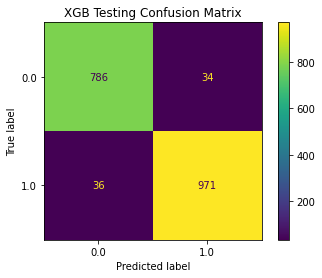

In [ ]:
y_pred = xgb_clf.predict(change_columns(small_X_test))
print('Evaluation Metrics:')
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 Score: ' + str(f1_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
plot_confusion_matrix(xgb_clf,change_columns(small_X_test),y_test, values_format='0.0f')
plt.title("XGB Testing Confusion Matrix")
plt.show()

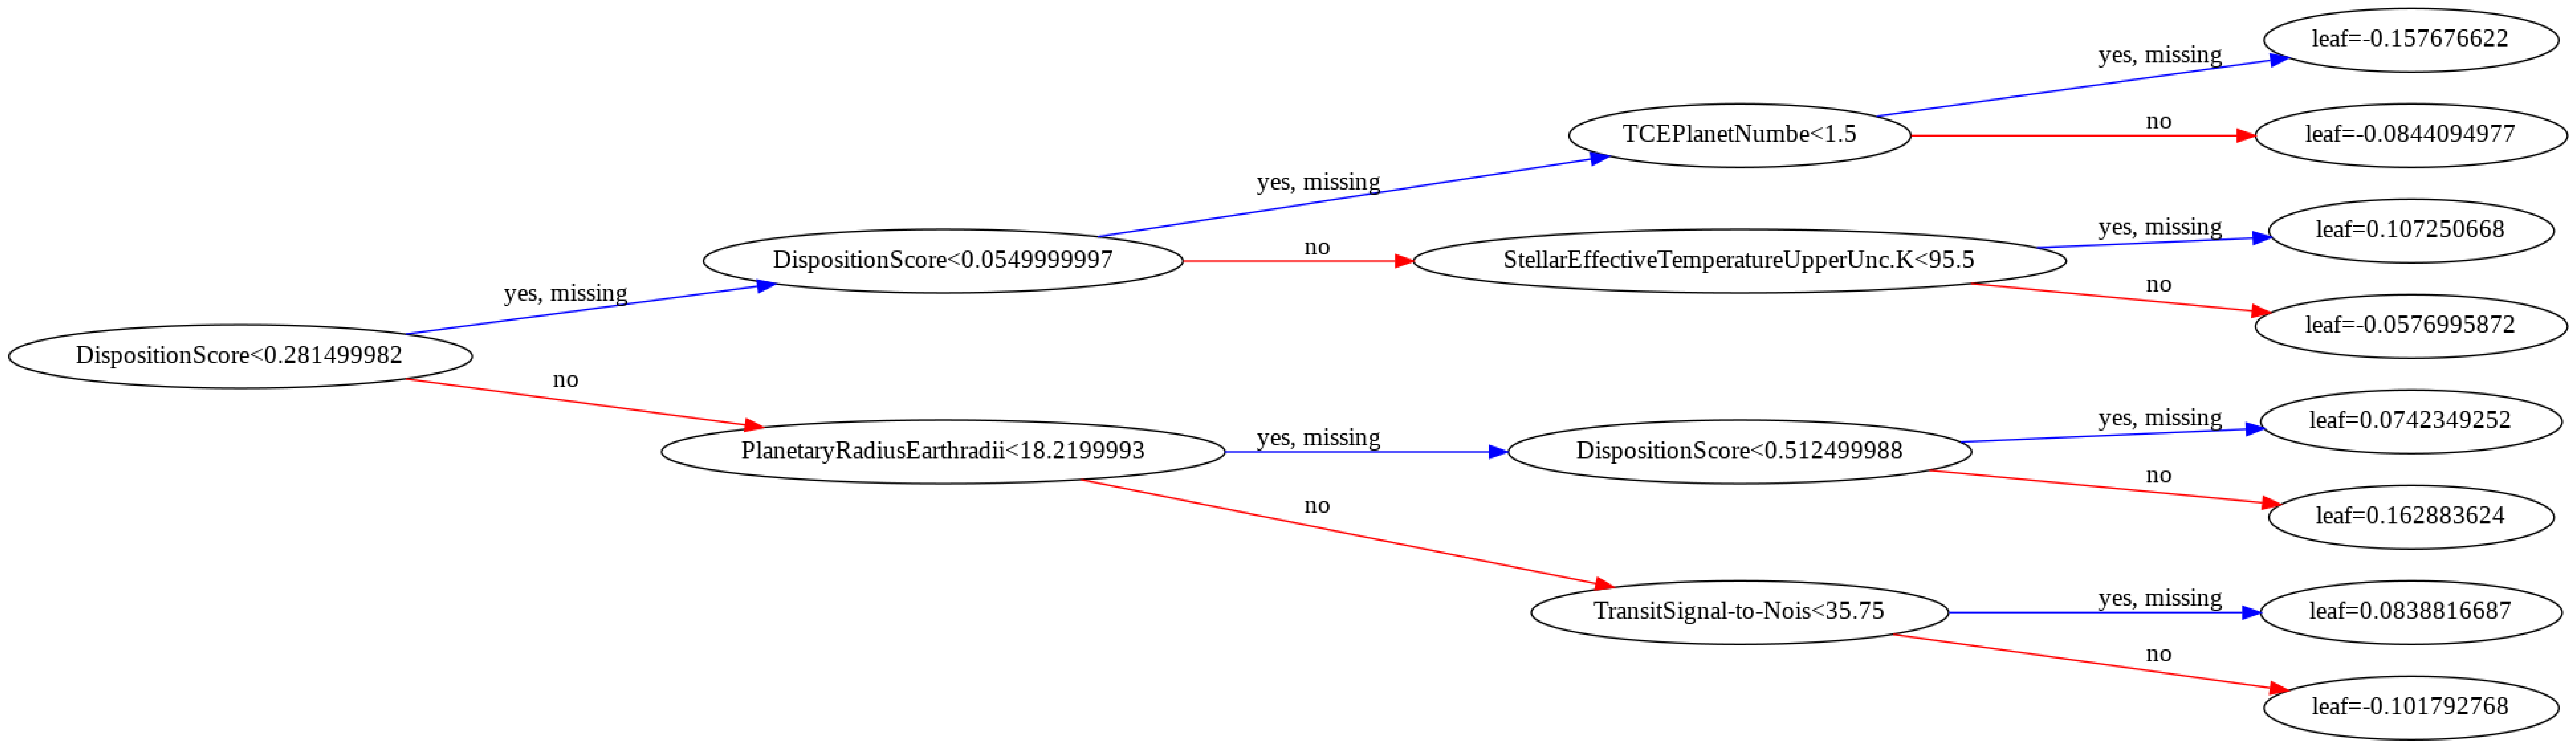

In [ ]:
plot_tree(xgb_clf, num_trees=2, rankdir='LR')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(200, 200)
fig.show()

# Saving the best model to drive

The best model is XGBoost Decision Tree Classifier with 5 features: Disposition Score, Planet Radius, TCE Planet Number, Stellar Temperature, and Transit Signal-to-Noise

In [ ]:
import pickle

with open(os.path.join(main_path, 'best_model.pkl'), 'wb') as handle:
    pickle.dump(xgb_clf, handle)

# Deploying to IBM Cloud

In [ ]:
with open(os.path.join(main_path, 'best_model.pkl'), 'rb') as handle:
    best_model = pickle.load(handle)

The Api key is secret to the team members only

In [ ]:
api_key = getpass("Api Key: ")

Api Key: ··········


In [ ]:
location = "eu-gb"

wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}
client = APIClient(wml_credentials)

In [ ]:
client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  ----------------------  ------------------------
ID                                    NAME                    CREATED
0c2b26ba-067f-44a9-8041-94e1fb366bdc  interstellar-explorers  2021-04-05T11:04:00.946Z
------------------------------------  ----------------------  ------------------------


In [ ]:
client.set.default_space("0c2b26ba-067f-44a9-8041-94e1fb366bdc")

'SUCCESS'

In [ ]:
sys.version

'3.7.10 (default, Feb 20 2021, 21:17:23) \n[GCC 7.5.0]'

In [ ]:
import xgboost
xgboost.__version__

'0.90'

In [ ]:
software_spec_uid_xg = client.software_specifications.get_uid_by_name("default_py3.7")
software_spec_uid_xg

'e4429883-c883-42b6-87a8-f419d64088cd'

In [ ]:
metadata = {
    client.repository.ModelMetaNames.NAME: 'Interstellar Explorers Model',
    client.repository.ModelMetaNames.TYPE: 'xgboost_0.90',
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid_xg
}
published_model = client.repository.store_model(
    model=best_model,
    meta_props=metadata,
    training_data=small_X_train,
    training_target=y_train)

# Testing deployed model

In [ ]:
models_details = client.repository.list_models()

------------------------------------  ---------------------------------  ------------------------  ------------
ID                                    NAME                               CREATED                   TYPE
8cf4a70b-9cc5-4dd3-b4b1-e1f6d03cbfd7  Interstellar Explorers Model       2021-04-10T11:04:08.002Z  xgboost_0.90
a1e4929e-a8fd-46d7-a242-15f0be0b5bd3  Exoplanet XGBoost Classsification  2021-04-05T11:12:44.002Z  xgboost_0.90
------------------------------------  ---------------------------------  ------------------------  ------------


In [ ]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Interstellar Explorers Model ",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = client.deployments.create("8cf4a70b-9cc5-4dd3-b4b1-e1f6d03cbfd7", meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: '8cf4a70b-9cc5-4dd3-b4b1-e1f6d03cbfd7' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='f4a9c694-eb4e-400c-9cf0-79ab027cc102'
------------------------------------------------------------------------------------------------




In [ ]:
client.deployments.list()

------------------------------------  -----------------------------------------------  -----  ------------------------
GUID                                  NAME                                             STATE  CREATED
f4a9c694-eb4e-400c-9cf0-79ab027cc102  Interstellar Explorers Model                     ready  2021-04-10T11:04:48.351Z
45a3b400-2931-4671-8038-2a0127624a2c  Deployed Exoplanet Model                         ready  2021-04-10T06:55:34.050Z
5253510b-be93-4942-88f5-62025986bd00  Deployment of Exoplanet XGBoost Classsification  ready  2021-04-05T11:14:03.319Z
------------------------------------  -----------------------------------------------  -----  ------------------------


In [ ]:
def get_prediction(x, describe=False):
    scoring_payload = {"input_data": [{"values": [list(x)]}]}
    predictions = client.deployments.score("f4a9c694-eb4e-400c-9cf0-79ab027cc102", scoring_payload)
    exoplanet_probability = np.round(predictions['predictions'][0]['values'][0][0], 3)
    if describe:
        print(f"There is {exoplanet_probability * 100} % chance of given planet being an exoplanet.")
        return None
    return exoplanet_probability

In [ ]:
get_prediction(small_X_test.iloc[-2], describe=True) #this planet is a known exoplanet

There is 98.9 % chance of given planet being an exoplanet.


# Sample Predictions

In [ ]:
def get_random_predictions(n=1):
    for i in range(n):
        sample_input = small_X_test.sample(1)
        sample_y = y_test[sample_input.index]

        print("Model Prediction:")
        get_prediction(sample_input.iloc[0], describe=True)

        print("Reality:")
        if sample_y.iloc[0] == 1:
            print('The planet is an exoplanet.')
        else:
            print('The planet is NOT an exoplanet.')
        
        if i != n-1:
            print('\n \n ---------------------------------- \n')

In [ ]:
get_random_predictions(10)

Model Prediction:
There is 98.7 % chance of given planet being an exoplanet.
Reality:
The planet is an exoplanet.

 
 ---------------------------------- 

Model Prediction:
There is 4.3 % chance of given planet being an exoplanet.
Reality:
The planet is NOT an exoplanet.

 
 ---------------------------------- 

Model Prediction:
There is 99.4 % chance of given planet being an exoplanet.
Reality:
The planet is an exoplanet.

 
 ---------------------------------- 

Model Prediction:
There is 99.2 % chance of given planet being an exoplanet.
Reality:
The planet is an exoplanet.

 
 ---------------------------------- 

Model Prediction:
There is 0.8 % chance of given planet being an exoplanet.
Reality:
The planet is NOT an exoplanet.

 
 ---------------------------------- 

Model Prediction:
There is 1.7000000000000002 % chance of given planet being an exoplanet.
Reality:
The planet is NOT an exoplanet.

 
 ---------------------------------- 

Model Prediction:
There is 99.2 % chance of gi

# Get custom predictions

In [ ]:
#@markdown Input following data to predict if the planet is an exoplanet or not.

Disposition_Score = 0.88 #@param {type:"slider", min:0, max:1, step:0.01}
Planet_Radius =   17.56#@param {type: "number"}
TCE_Planet_Number = "1"  #@param [1, 2, 3, 4, 5, 6]
Stellar_Effective_Temperature =   112.7#@param {type: "number"}
Transit_Signal_to_Noise = 42.5  #@param {type: "number"}
#@markdown ---

    inp_data = [Disposition_Score, Planet_Radius,
                TCE_Planet_Number, Stellar_Effective_Temperature,
                Transit_Signal_to_Noise]

get_prediction(inp_data, describe=True)

There is 70.6 % chance of given planet being an exoplanet.
